In [59]:
import pandas as pd

# 1. 파일 경로 리스트
file_paths = [
    "서울교통공사_역별 시간대별 승하차인원(20.1~20.12).csv",
    "서울교통공사_역별 시간대별 승하차인원(21.1~21.12).csv",
    "서울교통공사_역별 시간대별 승하차인원(22.1~22.12).csv",
    "서울교통공사_역별 시간대별 승하차인원(23.1~23.12).csv",
    "서울교통공사_역별 시간대별 승하차인원(24.1~24.12).csv"
]

# 2. 표준 컬럼명 지정 (2024 기준)
standard_columns = [
    '연번', '날짜', '호선', '역번호', '역명', '구분',
    '06시 이전', '06시~07시', '07시~08시', '08시~09시', '09시~10시',
    '10시~11시', '11시~12시', '12시~13시', '13시~14시', '14시~15시',
    '15시~16시', '16시~17시', '17시~18시', '18시~19시', '19시~20시',
    '20시~21시', '21시~22시', '22시~23시', '23시~24시', '24시 이후'
]

# 3. 파일 불러와 컬럼명 통일 후 병합
df_list = []

for path in file_paths:
    df = pd.read_csv(path, encoding='cp949', low_memory=False)
    df.columns = standard_columns  # 강제로 컬럼명 덮어쓰기
    df_list.append(df)

# 4. 병합
df_merged = pd.concat(df_list, ignore_index=True)

# 결과 미리보기
df_merged


,연번,날짜,호선,역번호,역명,구분,06시 이전,06시~07시,07시~08시,08시~09시,...,15시~16시,16시~17시,17시~18시,18시~19시,19시~20시,20시~21시,21시~22시,22시~23시,23시~24시,24시 이후
0,1,2020-01-01,1호선,150,서울역,승차,356,280,313,774,...,2972,3194,3342,3002,2857,2311,2523,1830,987,25.0
1,2,2020-01-01,1호선,150,서울역,하차,235,952,828,1043,...,2286,2354,2261,1922,1696,1620,1181,768,426,77.0
2,3,2020-01-01,1호선,151,시청,승차,105,118,123,206,...,873,1019,1234,1383,1271,1061,991,572,217,2.0
3,4,2020-01-01,1호선,151,시청,하차,81,223,334,570,...,885,783,849,602,435,293,273,174,149,26.0
4,5,2020-01-01,1호선,152,종각,승차,798,366,198,236,...,1636,1748,1890,1879,1827,1955,1800,1259,406,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1004409,199406,2024-12-31,8호선,2826,수진,하차,14,85,152,477,...,355,414,465,468,376,261,248,246,175,68.0
1004410,199407,2024-12-31,8호선,2827,모란,승차,80,103,332,400,...,389,537,440,381,247,136,170,140,90,50.0
1004411,199408,2024-12-31,8호선,2827,모란,하차,19,109,138,428,...,263,340,340,374,281,193,212,207,141,128.0
1004412,199409,2024-12-31,8호선,2828,남위례,승차,44,236,686,811,...,656,469,556,513,285,245,216,213,75,46.0


In [60]:
# 시간대(승-하차 인원) 컬럼만 추출
time_cols = df_merged.columns.difference(
    ["연번", "날짜", "호선", "역번호", "역명", "구분"]
)

# 두 행씩 묶을 ‘pair’ 번호 부여
df_merged["pair"] = df_merged.index // 2          # 0,0,1,1,2,2 …

# 승차·하차 합계 계산
sum_df = df_merged.groupby("pair")[time_cols].sum()

# 날짜·역명 등 메타데이터는 짝수행(승차)에서만 가져옴
meta = (
    df_merged.loc[df_merged.index % 2 == 0, ["연번", "날짜", "호선", "역번호", "역명", "구분"]]
           .set_index(df_merged.loc[df_merged.index % 2 == 0, "pair"])
)

# 합치고 정리
df_merged = pd.concat([meta, sum_df], axis=1).reset_index(drop=True)
df_merged = df_merged.drop(columns=["구분"], axis=1)

clos = df_merged.columns[5:]
df_merged['하루_유동인구'] = df_merged[clos].sum(axis=1)
df_merged

,연번,날짜,호선,역번호,역명,06시 이전,06시~07시,07시~08시,08시~09시,09시~10시,...,16시~17시,17시~18시,18시~19시,19시~20시,20시~21시,21시~22시,22시~23시,23시~24시,24시 이후,하루_유동인구
0,1,2020-01-01,1호선,150,서울역,591,1232,1141,1817,2617,...,5548,5603,4924,4553,3931,3704,2598,1413,102.0,66726.0
1,3,2020-01-01,1호선,151,시청,186,341,457,776,929,...,1802,2083,1985,1706,1354,1264,746,366,28.0,22820.0
2,5,2020-01-01,1호선,152,종각,869,557,493,747,1165,...,3198,3242,3011,2552,2500,2144,1484,552,31.0,36924.0
3,7,2020-01-01,1호선,153,종로3가,391,336,343,561,905,...,2972,2826,2198,1713,1423,1241,948,460,91.0,32652.0
4,9,2020-01-01,1호선,154,종로5가,82,174,237,383,631,...,2572,2263,1581,1281,1087,807,497,212,17.0,24738.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
502202,199401,2024-12-31,8호선,2824,단대오거리,393,864,2026,2562,1302,...,1713,1830,2072,1463,890,800,656,367,190.0,23485.0
502203,199403,2024-12-31,8호선,2825,신흥,145,339,742,1082,582,...,908,930,1004,670,455,389,329,176,64.0,11425.0
502204,199405,2024-12-31,8호선,2826,수진,148,309,759,1225,646,...,797,817,840,588,399,381,316,204,96.0,10926.0
502205,199407,2024-12-31,8호선,2827,모란,99,212,470,828,460,...,877,780,755,528,329,382,347,231,178.0,9825.0


In [61]:
average_df = (df_merged.groupby('역명')['하루_유동인구'].mean().reset_index().rename(columns={'하루_유동인구': '하루_평균_유동인구'}).reset_index(drop=True))
average_df


,역명,하루_평균_유동인구
0,가락시장,18089.933771
1,가산디지털단지,86285.446086
2,강남,169383.679803
3,강남구청,34616.923372
4,강동,38652.519978
...,...,...
250,홍제,36834.661741
251,화곡,58107.175698
252,화랑대(서울여대입구),21933.205802
253,회현(남대문시장),52983.953476


In [66]:
import pandas as pd

# 두 데이터프레임 불러오기
fire = pd.read_csv('소화기.csv', encoding='cp949')  # 첫 번째 데이터: 소화기 수량
mask = pd.read_csv('마스크.csv', encoding='cp949')  # 두 번째 데이터: 마스크 수량

# 역명 전처리 - '역' 글자 제거
# df2['역명'] = df2['역명'].str.replace('역$', '', regex=True).str.strip()
# df1['역명'] = df1['역명'].str.strip()

# 병합
fire_mask = pd.merge(fire, mask, on='역명', how='outer')

# 결과 확인
fire_mask

,역명,소화기_수량,화재용 긴급대피마스크_수량
0,신내,12.0,NaN
1,장암,13.0,NaN
2,지축,19.0,NaN
3,구산,20.0,150.0
4,창신,21.0,250.0
...,...,...,...
234,종로3가,144.0,800.0
235,잠실,145.0,600.0
236,방화,NaN,150.0
237,개화산,NaN,150.0


In [ ]:
import pandas as pd

# 1. 소화기 & 마스크 수량 데이터 입력 (예시 — 실제로는 CSV에서 불러오면 됨)
people_data = average_df

merged = pd.merge(people_data, fire_mask, on='역명', how='left')
merged

# 4. 보유률 계산
merged['마스크_보급률(개/명)'] = merged['화재용 긴급대피마스크_수량'] / merged['하루_평균_유동인구']

# 5. 결과 정렬 및 출력
merged = merged.dropna()
merged

,역명,하루_평균_유동인구,소화기_수량,화재용 긴급대피마스크_수량,마스크_보급률(개/명)
0,가락시장,18089.933771,77.0,250.0,0.013820
1,가산디지털단지,86285.446086,43.0,310.0,0.003593
2,강남,169383.679803,52.0,250.0,0.001476
3,강남구청,34616.923372,43.0,350.0,0.010111
4,강동,38652.519978,69.0,200.0,0.005174
...,...,...,...,...,...
248,혜화,72896.902025,41.0,194.0,0.002661
249,홍대입구,138109.655720,64.0,250.0,0.001810
250,홍제,36834.661741,57.0,200.0,0.005430
251,화곡,58107.175698,28.0,250.0,0.004302


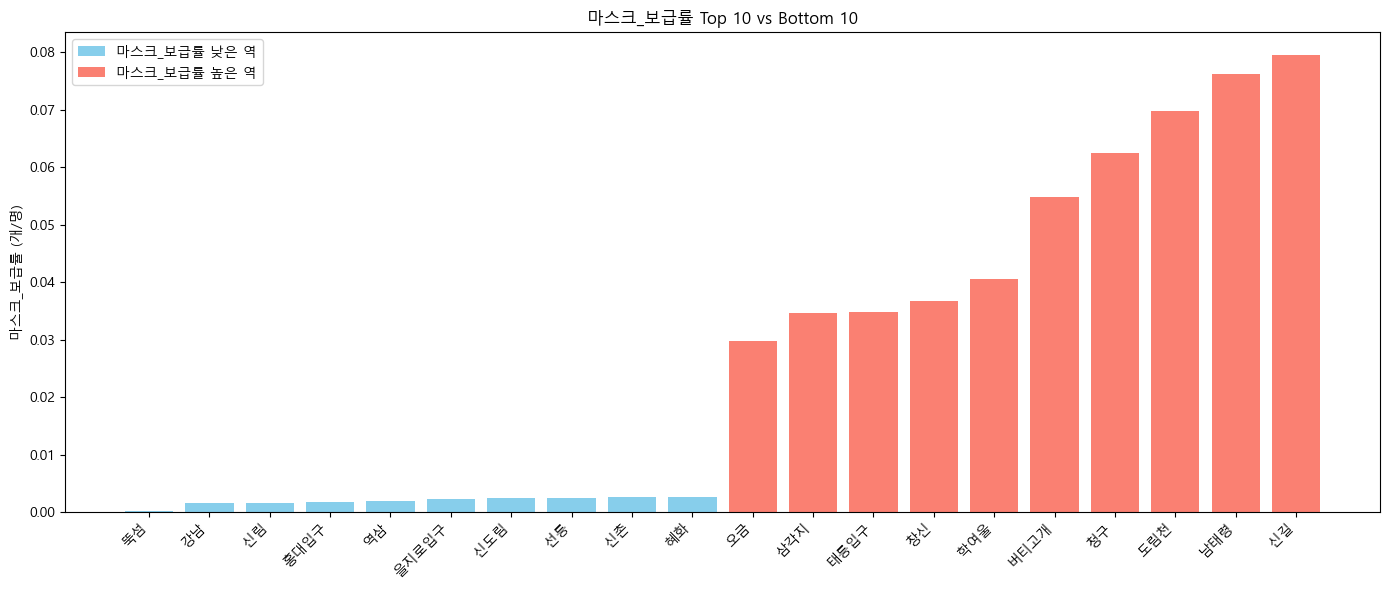

In [69]:
import pandas as pd
import matplotlib.pyplot as plt

# 한글 깨짐 방지
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# 1. 소화기 밀도 상위/하위 10개 추출
bottom_fire = merged.nsmallest(10, '마스크_보급률(개/명)')
top_fire = merged.nlargest(10, '마스크_보급률(개/명)').sort_values('마스크_보급률(개/명)')  # 작은 값부터 그리기 위해 정렬

# 2. 시각화
plt.figure(figsize=(14, 6))

# 하위 10개 (왼쪽)
plt.bar(bottom_fire['역명'], bottom_fire['마스크_보급률(개/명)'], color='skyblue', label='마스크_보급률 낮은 역')

# 상위 10개 (오른쪽)
plt.bar(top_fire['역명'], top_fire['마스크_보급률(개/명)'], color='salmon', label='마스크_보급률 높은 역')

# 라벨 & 제목
plt.xticks(rotation=45, ha='right')
plt.ylabel('마스크_보급률 (개/명)')
plt.title('마스크_보급률 Top 10 vs Bottom 10')
plt.legend()
plt.tight_layout()
plt.show()
